# Model Training - Genre Classification CNN

This notebook trains the CNN model for music genre classification using the preprocessed mel spectrograms.

**Key Steps:**
1. Load preprocessed data
2. Initialize PyTorch CNN model
3. Train with early stopping and learning rate scheduling
4. Evaluate on test set
5. Visualize training history
6. Save model and metrics

## 1. Setup and Imports

In [7]:
import sys
from pathlib import Path
import torch

# Add src to path
sys.path.append(str(Path.cwd().parent / 'src'))

from models.cnn import GenreClassifierCNN
from models.trainer import GenreClassifierTrainer, load_processed_data

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1
CUDA available: False


## 2. Load Preprocessed Data

In [8]:
data_path = Path.cwd().parent / 'data' / 'processed'

X_train, y_train, X_val, y_val, X_test, y_test, metadata = load_processed_data(data_path)

print("\nDataset shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")

print("\nGenre mapping:")
for genre, idx in sorted(metadata['genre_to_id'].items(), key=lambda x: x[1]):
    print(f"  {idx}: {genre}")

Loaded data from /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/data/processed
  Train: (698, 128, 1292, 1), Labels: (698,)
  Val: (150, 128, 1292, 1), Labels: (150,)
  Test: (150, 128, 1292, 1), Labels: (150,)

Dataset shapes:
  X_train: (698, 128, 1292, 1), y_train: (698,)
  X_val: (150, 128, 1292, 1), y_val: (150,)
  X_test: (150, 128, 1292, 1), y_test: (150,)

Genre mapping:
  0: blues
  1: classical
  2: country
  3: disco
  4: hiphop
  5: jazz
  6: metal
  7: pop
  8: reggae
  9: rock


## 3. Initialize Model

We use a 4-block CNN architecture:
- **Block 1-4**: Conv layers with BatchNorm, ReLU, MaxPooling, Dropout
- **Features**: 32 → 64 → 128 → 256 filters
- **Classifier**: Global Average Pooling + 2 FC layers
- **Grad-CAM Ready**: Stores intermediate activations for explainability

In [9]:
# Initialize model
num_classes = len(metadata['genre_to_id'])
model = GenreClassifierCNN(num_classes=num_classes)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: {model.__class__.__name__}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(model)

Model: GenreClassifierCNN
Total parameters: 1,440,618
Trainable parameters: 1,440,618

Model architecture:
GenreClassifierCNN(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

## 4. Train Model

Training configuration:
- **Optimizer**: Adam with learning rate 0.001
- **Loss**: CrossEntropyLoss
- **Batch size**: 32
- **Max epochs**: 20 
- **Early stopping**: Patience of 5 epochs
- **LR scheduling**: ReduceLROnPlateau (factor=0.5, patience=3)

In [10]:
# Initialize trainer
results_dir = Path.cwd().parent / 'results'
trainer = GenreClassifierTrainer(model, results_dir=results_dir)

# Train model
history = trainer.train(
    X_train, y_train,
    X_val, y_val,
    epochs=20,
    batch_size=32,
    learning_rate=0.001,
    model_name='genre_cnn_pytorch',
    patience=5
)

Using device: cpu

Training genre_cnn_pytorch...
Training samples: 698
Validation samples: 150
Input shape: (128, 1292, 1)


Epoch 1/20: 100%|██████████| 22/22 [03:20<00:00,  9.13s/it, loss=2.3233, acc=15.33%]



Epoch 1/20:
  Train Loss: 2.3233, Train Acc: 0.1533
  Val Loss: 2.2836, Val Acc: 0.1600
  ✓ Best model saved (val_acc: 0.1600)

----------------------------------------


Epoch 2/20: 100%|██████████| 22/22 [03:20<00:00,  9.12s/it, loss=2.0391, acc=23.93%]



Epoch 2/20:
  Train Loss: 2.0391, Train Acc: 0.2393
  Val Loss: 2.1564, Val Acc: 0.1933
  ✓ Best model saved (val_acc: 0.1933)

----------------------------------------


Epoch 3/20: 100%|██████████| 22/22 [03:19<00:00,  9.08s/it, loss=1.8438, acc=29.94%]



Epoch 3/20:
  Train Loss: 1.8438, Train Acc: 0.2994
  Val Loss: 1.9605, Val Acc: 0.2333
  ✓ Best model saved (val_acc: 0.2333)

----------------------------------------


Epoch 4/20: 100%|██████████| 22/22 [03:18<00:00,  9.03s/it, loss=1.7655, acc=35.10%]



Epoch 4/20:
  Train Loss: 1.7655, Train Acc: 0.3510
  Val Loss: 1.7463, Val Acc: 0.3467
  ✓ Best model saved (val_acc: 0.3467)

----------------------------------------


Epoch 5/20: 100%|██████████| 22/22 [03:18<00:00,  9.01s/it, loss=1.7372, acc=35.39%]



Epoch 5/20:
  Train Loss: 1.7372, Train Acc: 0.3539
  Val Loss: 1.6785, Val Acc: 0.3533
  ✓ Best model saved (val_acc: 0.3533)

----------------------------------------


Epoch 6/20: 100%|██████████| 22/22 [03:17<00:00,  8.98s/it, loss=1.6708, acc=37.97%]



Epoch 6/20:
  Train Loss: 1.6708, Train Acc: 0.3797
  Val Loss: 1.4974, Val Acc: 0.4267
  ✓ Best model saved (val_acc: 0.4267)

----------------------------------------


Epoch 7/20: 100%|██████████| 22/22 [03:18<00:00,  9.02s/it, loss=1.5782, acc=39.40%]



Epoch 7/20:
  Train Loss: 1.5782, Train Acc: 0.3940
  Val Loss: 1.7237, Val Acc: 0.3733

----------------------------------------


Epoch 8/20: 100%|██████████| 22/22 [03:21<00:00,  9.14s/it, loss=1.5770, acc=38.25%]



Epoch 8/20:
  Train Loss: 1.5770, Train Acc: 0.3825
  Val Loss: 1.5486, Val Acc: 0.4400
  ✓ Best model saved (val_acc: 0.4400)

----------------------------------------


Epoch 9/20: 100%|██████████| 22/22 [03:16<00:00,  8.95s/it, loss=1.5229, acc=42.69%]



Epoch 9/20:
  Train Loss: 1.5229, Train Acc: 0.4269
  Val Loss: 2.8166, Val Acc: 0.1800

----------------------------------------


Epoch 10/20: 100%|██████████| 22/22 [03:20<00:00,  9.11s/it, loss=1.5775, acc=43.41%]



Epoch 10/20:
  Train Loss: 1.5775, Train Acc: 0.4341
  Val Loss: 1.3932, Val Acc: 0.4933
  ✓ Best model saved (val_acc: 0.4933)

----------------------------------------


Epoch 11/20: 100%|██████████| 22/22 [03:20<00:00,  9.13s/it, loss=1.5298, acc=43.70%]



Epoch 11/20:
  Train Loss: 1.5298, Train Acc: 0.4370
  Val Loss: 1.4910, Val Acc: 0.4200

----------------------------------------


Epoch 12/20: 100%|██████████| 22/22 [03:17<00:00,  8.99s/it, loss=1.4868, acc=45.42%]



Epoch 12/20:
  Train Loss: 1.4868, Train Acc: 0.4542
  Val Loss: 1.3967, Val Acc: 0.4867

----------------------------------------


Epoch 13/20: 100%|██████████| 22/22 [03:18<00:00,  9.01s/it, loss=1.4466, acc=45.85%]



Epoch 13/20:
  Train Loss: 1.4466, Train Acc: 0.4585
  Val Loss: 1.6693, Val Acc: 0.3667

----------------------------------------


Epoch 14/20: 100%|██████████| 22/22 [03:17<00:00,  8.97s/it, loss=1.3828, acc=48.42%]



Epoch 14/20:
  Train Loss: 1.3828, Train Acc: 0.4842
  Val Loss: 1.3470, Val Acc: 0.5067
  ✓ Best model saved (val_acc: 0.5067)

----------------------------------------


Epoch 15/20: 100%|██████████| 22/22 [03:18<00:00,  9.03s/it, loss=1.3984, acc=50.14%]



Epoch 15/20:
  Train Loss: 1.3984, Train Acc: 0.5014
  Val Loss: 1.5987, Val Acc: 0.3867

----------------------------------------


Epoch 16/20: 100%|██████████| 22/22 [03:18<00:00,  9.03s/it, loss=1.3678, acc=50.29%]



Epoch 16/20:
  Train Loss: 1.3678, Train Acc: 0.5029
  Val Loss: 1.2885, Val Acc: 0.5267
  ✓ Best model saved (val_acc: 0.5267)

----------------------------------------


Epoch 17/20: 100%|██████████| 22/22 [03:22<00:00,  9.22s/it, loss=1.3575, acc=50.43%]



Epoch 17/20:
  Train Loss: 1.3575, Train Acc: 0.5043
  Val Loss: 1.3434, Val Acc: 0.5067

----------------------------------------


Epoch 18/20: 100%|██████████| 22/22 [03:18<00:00,  9.00s/it, loss=1.3645, acc=49.14%]



Epoch 18/20:
  Train Loss: 1.3645, Train Acc: 0.4914
  Val Loss: 1.6297, Val Acc: 0.4467

----------------------------------------


Epoch 19/20: 100%|██████████| 22/22 [03:16<00:00,  8.93s/it, loss=1.3503, acc=49.71%]



Epoch 19/20:
  Train Loss: 1.3503, Train Acc: 0.4971
  Val Loss: 1.2379, Val Acc: 0.5667
  ✓ Best model saved (val_acc: 0.5667)

----------------------------------------


Epoch 20/20: 100%|██████████| 22/22 [03:16<00:00,  8.92s/it, loss=1.3131, acc=52.01%]



Epoch 20/20:
  Train Loss: 1.3131, Train Acc: 0.5201
  Val Loss: 1.3566, Val Acc: 0.4800

----------------------------------------

Model saved to /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/results/models


## 5. Visualize Training History

Training history plot saved to /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/results/figures/training_history.png


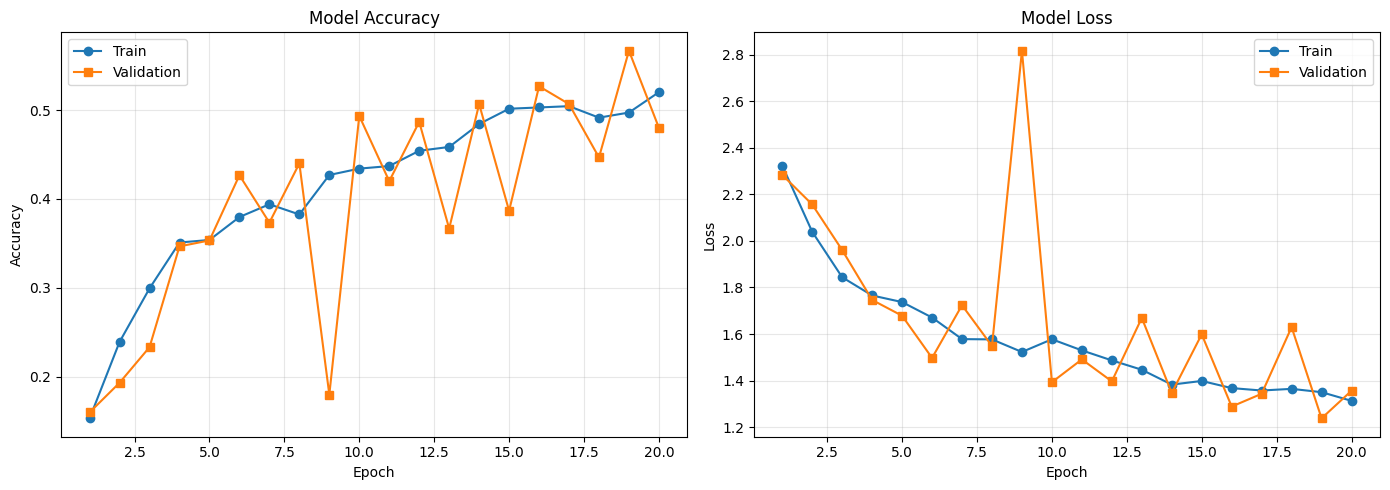

In [11]:
import matplotlib.pyplot as plt

# Plot training history
save_path = results_dir / 'figures' / 'training_history.png'
trainer.plot_training_history(save_path=save_path)

The training curves show:
- **Accuracy**: How well the model classifies genres over epochs
- **Loss**: Cross-entropy loss decrease over time
- **Overfitting check**: Gap between train and validation curves

If validation accuracy plateaus or decreases while training accuracy increases, the model is overfitting.

## 6. Evaluate on Test Set

Load the best model (based on validation accuracy) and evaluate on the held-out test set.

In [12]:
# Load best model
best_model_path = results_dir / 'models' / 'genre_cnn_pytorch_best.pth'
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from {best_model_path}")

# Evaluate
test_results = trainer.evaluate(X_test, y_test, batch_size=32)

print(f"\nTest Results:")
print(f"  Loss: {test_results['test_loss']:.4f}")
print(f"  Accuracy: {test_results['test_accuracy']:.4f}")
print(f"  Samples: {test_results['num_samples']}")

Loaded best model from /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/results/models/genre_cnn_pytorch_best.pth

Evaluating on test set...


Testing: 100%|██████████| 5/5 [00:10<00:00,  2.06s/it]

Test Loss: 1.2367
Test Accuracy: 0.5267

Test Results:
  Loss: 1.2367
  Accuracy: 0.5267
  Samples: 150


## 7. Save Training Metrics

Save all training metrics and results to JSON for future reference.

In [ ]:
# Combine all results
final_results = {
    'model_name': 'GenreClassifierCNN',
    'framework': 'PyTorch',
    'dataset': 'GTZAN',
    'num_classes': num_classes,
    'total_parameters': total_params,
    'trainable_parameters': trainable_params,
    'training_config': {
        'epochs': 20,
        'batch_size': 32,
        'learning_rate': 0.001,
        'optimizer': 'Adam',
        'loss': 'CrossEntropyLoss',
        'early_stopping_patience': 5,
        'lr_scheduler': 'ReduceLROnPlateau'
    },
    'test_loss': test_results['test_loss'],
    'test_accuracy': test_results['test_accuracy'],
    'num_test_samples': test_results['num_samples']
}

# Save metrics
trainer.save_training_metrics(final_results, filename='training_metrics.json')

print("\nTraining complete! ✓")
print(f"Best model saved to: {best_model_path}")
print(f"Metrics saved to: {results_dir / 'metrics' / 'training_metrics.json'}")
print(f"Training plot saved to: {results_dir / 'figures' / 'training_history.png'}")

Metrics saved to /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/results/metrics/training_metrics.json

Training complete! ✓
Best model saved to: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/results/models/genre_cnn_pytorch_best.pth
Metrics saved to: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/results/metrics/training_metrics.json
Training plot saved to: /Users/erikvh/Documents/University/Semester 5/Explainable AI/xai-music-genre-robustness/results/figures/training_history.png


## Summary

The CNN model has been successfully trained on the GTZAN dataset for music genre classification. Key outcomes:

1. **Model**: 4-block CNN with BatchNorm and Dropout
2. **Training**: Adam optimizer with learning rate scheduling and early stopping
3. **Evaluation**: Test accuracy on held-out test set
4. **Artifacts**: Best model checkpoint, final model, training metrics, and visualizations

**Next Steps:**
- Adversarial attack generation (Notebook 04)
- Grad-CAM visualization (Notebook 05)
- Robustness analysis under perturbations